In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Vision libraries
import timm  # Library for pre-trained ViT models
import torchvision
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data handling
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


c:\Users\csury\anaconda3\envs\att_distill\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Load the pre-trained teacher model (ViT) from checkpoint with CIFAR-100 classes
teacher_model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=100)
teacher_checkpoint = torch.load('teacher_checkpoints/best_teacher_model_epoch_2.pth', map_location=device)
teacher_model.load_state_dict(teacher_checkpoint['model_state_dict'])
teacher_model.to(device)
teacher_model.eval()  # Freeze teacher

# Load the baseline student model (ResNet18) from checkpoint
student_model = torchvision.models.resnet18(num_classes=100)  # assuming CIFAR-100
student_checkpoint = torch.load('student_checkpoints/best_model_epoch_4.pth', map_location=device)
student_model.load_state_dict(student_checkpoint['model_state_dict'])
student_model.to(device)


C:\Users\csury\AppData\Local\Temp\ipykernel_20720\252909734.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_checkpoint = torch.load('teacher_checkpoints/best_tea

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Define a hook function to extract attention maps.
def get_attention_hook(module, input, output):
    """
    Hook function to capture attention maps.
    Adjust the extraction logic if your model outputs a dictionary or tuple.
    """
    # If your block outputs a dictionary containing 'attn_weights', use that:
    if isinstance(output, dict) and 'attn_weights' in output:
        module.attention_maps = output['attn_weights']
    else:
        # Otherwise, assume the output itself is the attention map.
        module.attention_maps = output

# Register the hook on each transformer block in the teacher model.
# For timm's Vision Transformer, these blocks are typically stored in teacher_model.blocks.
for block in teacher_model.blocks:
    block.register_forward_hook(get_attention_hook)


In [4]:
# # Attention Projection Layer for Student

# class StudentWithProjection(nn.Module):
#     def __init__(self, student_model, proj_in_channels=512, proj_out_channels=384):
#         """
#         student_model: the pre-trained baseline student (e.g., ResNet18)
#         proj_in_channels: number of channels from the feature map of student_model (for ResNet18, typically 512)
#         proj_out_channels: target dimension to match the teacher’s attention dimension
#                            (for ViT-Small, it might be 384 or 768, depending on your configuration)
#         """
#         super(StudentWithProjection, self).__init__()
#         self.student = student_model
        
#         # Projection layer: a 1x1 convolution to match the teacher's attention channels
#         self.attention_proj = nn.Conv2d(in_channels=proj_in_channels, 
#                                         out_channels=proj_out_channels, 
#                                         kernel_size=1)
    
#     def forward(self, x):
#         # Forward pass through the student model up to the last convolutional block.
#         x = self.student.conv1(x)
#         x = self.student.bn1(x)
#         x = self.student.relu(x)
#         x = self.student.maxpool(x)
#         x = self.student.layer1(x)
#         x = self.student.layer2(x)
#         x = self.student.layer3(x)
#         features = self.student.layer4(x)  # features for distillation
        
#         # Project the feature map to the teacher's attention dimensions.
#         projected_features = self.attention_proj(features)
        
#         # Continue with classification head:
#         pooled = self.student.avgpool(features)
#         pooled = torch.flatten(pooled, 1)
#         logits = self.student.fc(pooled)
        
#         # Return both logits and the projected features
#         return logits, projected_features

# # Instantiate the extended student model and move it to the appropriate device.
# student_with_proj = StudentWithProjection(student_model).to(device)





# Define the custom student model with projection
class StudentWithProjection(nn.Module):
    def __init__(self, student_model, proj_in_channels=512, proj_out_channels=384):
        super(StudentWithProjection, self).__init__()
        # Directly assign the student's layers to this module's attributes
        self.conv1 = student_model.conv1
        self.bn1 = student_model.bn1
        self.relu = student_model.relu
        self.maxpool = student_model.maxpool
        self.layer1 = student_model.layer1
        self.layer2 = student_model.layer2
        self.layer3 = student_model.layer3
        self.layer4 = student_model.layer4
        self.avgpool = student_model.avgpool
        self.fc = student_model.fc
        
        # Attention projection layer remains
        self.attention_proj = nn.Conv2d(in_channels=proj_in_channels, 
                                        out_channels=proj_out_channels, 
                                        kernel_size=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        features = self.layer4(x)  # features for distillation
        
        # Apply projection to match teacher's attention dimensions
        projected_features = self.attention_proj(features)
        
        # Continue with classification head:
        pooled = self.avgpool(features)
        pooled = torch.flatten(pooled, 1)
        logits = self.fc(pooled)
        
        return logits, projected_features

# Instantiate and move to device
student_with_proj = StudentWithProjection(student_model).to(device)

# Load the checkpoint and update missing keys
checkpoint = torch.load('student_checkpoints/best_model_epoch_4.pth', map_location=device)
state_dict = checkpoint['model_state_dict']
model_dict = student_with_proj.state_dict()

# For any key missing in the checkpoint, fill it with the model's default value
for key in model_dict.keys():
    if key not in state_dict:
        print(f"Key {key} is missing; using default initialization.")
        state_dict[key] = model_dict[key]

# Load the updated state dictionary into the model
student_with_proj.load_state_dict(state_dict)


Key attention_proj.weight is missing; using default initialization.
Key attention_proj.bias is missing; using default initialization.


C:\Users\csury\AppData\Local\Temp\ipykernel_20720\205416372.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('student_checkpoints/best_model_epoc

<All keys matched successfully>

In [5]:
def compute_attention_entropy(attention_maps, eps=1e-8):
    """
    Compute the entropy of attention maps.
    The attention_maps are assumed to be raw scores; we first apply softmax.
    
    Args:
        attention_maps (Tensor): shape [B, tokens, features] (for your case, [B,197,384])
        eps (float): a small constant to prevent division by zero.
    
    Returns:
        Tensor: entropy values averaged over tokens, shape [B]
    """
    # Apply softmax along the last dimension to obtain valid probabilities
    att_soft = torch.softmax(attention_maps, dim=-1)
    # Although att_soft should already sum to 1, we normalize (with eps for safety)
    att_norm = att_soft / (att_soft.sum(dim=-1, keepdim=True) + eps)
    # Compute entropy: -sum(p * log(p)) along the last dimension
    entropy = -torch.sum(att_norm * torch.log(att_norm + eps), dim=-1)
    # Average over tokens (assuming tokens dimension is the second dimension)
    return entropy.mean(dim=1)


def dynamic_weighting(entropy, eps=1e-6):
    """
    Convert entropy scores into dynamic weights.
    
    Args:
        entropy (Tensor): shape [batch_size, tokens]
        eps (float): small constant to avoid division by zero.
    
    Returns:
        Tensor: normalized weights with the same shape as entropy.
    """
    # Lower entropy should give higher weight.
    weights = 1.0 / (entropy + eps)
    # Normalize weights across the tokens.
    return weights / weights.sum(dim=-1, keepdim=True)




def process_teacher_attention(att, target_size=(7,7), target_channels=384):
    """
    Process the teacher attention map to match the student feature shape.
    
    Args:
        att (Tensor): Teacher attention map. Ideally of shape [B, num_heads, tokens, tokens].
        target_size (tuple): Desired spatial size (e.g., (7,7)) for the output.
        target_channels (int): Desired channel count to match the student features.
        
    Returns:
        Tensor: Processed attention map with shape [B, target_channels, target_size[0], target_size[1]].
    """
    # Ensure att has 4 dimensions: [B, num_heads, tokens, tokens]
    if att.dim() == 2:
        att = att.unsqueeze(0)  # [B, tokens, tokens]
    if att.dim() == 3:
        att = att.unsqueeze(1)  # [B, 1, tokens, tokens]
    
    # Average over the head dimension → shape: [B, tokens, tokens]
    att_avg = att.mean(dim=1)
    
    # Only remove the class token if the number of tokens is large enough (e.g. > 1)
    B, T1, T2 = att_avg.shape
    if T1 == T2 and T1 > 1:
        # Check if the first token seems like a class token by inspecting its values;
        # if not, you might skip this removal.
        att_avg = att_avg[:, 1:, 1:]
    
    # Instead of using view (which requires a perfect square), use adaptive pooling:
    att_pooled = torch.nn.functional.adaptive_avg_pool2d(att_avg.unsqueeze(1), target_size)
    
    # Expand the channel dimension to match target_channels.
    att_processed = att_pooled.expand(-1, target_channels, -1, -1)
    
    return att_processed




In [6]:
# Define the data loaders for CIFAR-100 dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


#### Checkpoint checks

In [7]:
# Create a dummy input with the expected size (e.g., for a 224x224 image with 3 channels)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    teacher_output = teacher_model(dummy_input)
    student_output = student_with_proj(dummy_input)[0]  # [0] for logits

print("Teacher output statistics:")
print("  Min:", teacher_output.min().item())
print("  Max:", teacher_output.max().item())
print("  Mean:", teacher_output.mean().item())

print("\nStudent output statistics:")
print("  Min:", student_output.min().item())
print("  Max:", student_output.max().item())
print("  Mean:", student_output.mean().item())


Teacher output statistics:
  Min: -2.85207462310791
  Max: 5.0244011878967285
  Mean: 0.03972655534744263

Student output statistics:
  Min: -4.698159694671631
  Max: -2.007766008377075
  Mean: -3.1048648357391357


In [17]:
def check_model_weights(model, model_name="model"):
    for name, param in model.named_parameters():
        if param.requires_grad:
            if torch.isnan(param).any():
                print(f"NaN detected in {model_name} parameter: {name}")
            else:
                print(f"{model_name} parameter {name}: min={param.min().item():.4f}, max={param.max().item():.4f}, mean={param.mean().item():.4f}")


check_model_weights(student_with_proj, "Student")


Student parameter conv1.weight: min=-0.8460, max=1.0174, mean=-0.0001
Student parameter bn1.weight: min=-0.0000, max=0.5261, mean=0.2585
Student parameter bn1.bias: min=-0.6698, max=0.6841, mean=0.1847
Student parameter layer1.0.conv1.weight: min=-0.8022, max=0.6190, mean=-0.0028
Student parameter layer1.0.bn1.weight: min=0.1690, max=0.6502, mean=0.3394
Student parameter layer1.0.bn1.bias: min=-0.5264, max=0.3409, mean=-0.0287
Student parameter layer1.0.conv2.weight: min=-0.4940, max=0.2791, mean=-0.0011
Student parameter layer1.0.bn2.weight: min=0.1033, max=0.6348, mean=0.3297
Student parameter layer1.0.bn2.bias: min=-0.3990, max=0.4998, mean=0.0079
Student parameter layer1.1.conv1.weight: min=-0.5884, max=0.6509, mean=-0.0023
Student parameter layer1.1.bn1.weight: min=0.1776, max=0.4764, mean=0.3276
Student parameter layer1.1.bn1.bias: min=-0.4933, max=0.2391, mean=-0.0804
Student parameter layer1.1.conv2.weight: min=-0.3829, max=0.3098, mean=-0.0013
Student parameter layer1.1.bn2.we

In [18]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    student_output, _ = student_with_proj(dummy_input)
print("Student dummy output stats:", student_output.min(), student_output.max(), student_output.mean())


Student dummy output stats: tensor(-4.6319, device='cuda:0') tensor(-1.9692, device='cuda:0') tensor(-3.0868, device='cuda:0')


### Distillation training

#### 30 EPOCHS

In [7]:

# Create a directory for checkpoints if it doesn't exist
checkpoint_dir = 'distill_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(student_with_proj.parameters(), lr=1e-4)
num_epochs = 30  # Adjust based on your experiments
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# Initialize metrics dictionary for logging; we'll log epoch, losses, LR, and training accuracy
metrics = {
    'epoch': [],
    'combined_loss': [],
    'kl_loss': [],
    'mse_loss': [],
    'lr': [],
    'train_accuracy': []
}

# Variables for the best checkpoint and early stopping
best_loss = float('inf')
best_epoch = 0
patience = 3   # Early stopping patience
early_stop_counter = 0

# Hyperparameters for loss components
T = 3.0
alpha = 0.5

for epoch in range(num_epochs):
    student_with_proj.train()   # Set student model to training mode
    teacher_model.eval()        # Teacher remains frozen during fine-tuning
    running_combined_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0

    # Variables to compute training accuracy
    running_correct = 0
    running_total = 0

for epoch in range(num_epochs):
    student_with_proj.train()   # Set student model to training mode
    teacher_model.eval()        # Teacher remains frozen during fine-tuning
    running_combined_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0

    # Variables to compute training accuracy
    running_correct = 0
    running_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # ----- Teacher Forward Pass (no gradient) -----
        with torch.no_grad():
            teacher_logits = teacher_model(inputs)
            teacher_attentions = [block.attention_maps for block in teacher_model.blocks]
            # Debug: print the shape and stats of the first teacher attention map
            # if teacher_attentions[0] is not None:
            #     print("Teacher attention shape:", teacher_attentions[0].shape)
            #     print("Teacher attention stats: min =", teacher_attentions[0].min().item(), 
            #         "max =", teacher_attentions[0].max().item(), 
            #         "mean =", teacher_attentions[0].mean().item())
        
        # ----- Student Forward Pass -----
        student_logits, student_features = student_with_proj(inputs)
        student_attentions = [student_features]  # Use the projected features as student "attention"
        
        # Compute predictions for training accuracy
        preds = torch.argmax(student_logits, dim=1)
        running_total += labels.size(0)
        running_correct += (preds == labels).sum().item()
        
        # ----- Compute Dynamic Weights for Teacher's Attention -----
        entropy_weights = []
        for att in teacher_attentions:
            entropy = compute_attention_entropy(att)    # shape: [B, tokens]
            weights = dynamic_weighting(entropy)          # shape: [B, tokens]
            entropy_weights.append(weights)
        
        # ----- Compute Loss Components -----
        # KL Divergence Loss
        kl_loss = F.kl_div(
            F.log_softmax(student_logits / T, dim=1),
            F.softmax(teacher_logits / T, dim=1),
            reduction='batchmean'
        ) * (T * T)
        
        # MSE Loss: process the teacher attention map to match the student's projected features.
        # Here, we take the first teacher attention map and its corresponding dynamic weight.
        # Process teacher attention to have shape [B, student_channels, 7, 7]
        # Process teacher attention to have shape [B, student_channels, H, W] matching student_features
        processed_teacher_att = process_teacher_attention(
            teacher_attentions[0],
            target_size=(student_features.shape[2], student_features.shape[3]),
            target_channels=student_features.shape[1]
        )
        # Use an average of the dynamic weights (if needed) as a scalar multiplier
        avg_weight = entropy_weights[0].mean()
        mse_loss = avg_weight * F.mse_loss(student_attentions[0], processed_teacher_att)

        # Check for NaNs in the losses before proceeding
        if torch.isnan(kl_loss).any() or torch.isnan(mse_loss).any():
            print("NaN encountered in loss computation! Skipping this batch.")
            continue  # Optionally, skip the rest of this batch

        
        # Combined Loss: weighted sum of the KL and MSE losses.
        combined_loss = alpha * kl_loss + (1 - alpha) * mse_loss
        
        optimizer.zero_grad()
        combined_loss.backward()
        torch.nn.utils.clip_grad_norm_(student_with_proj.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        running_combined_loss += combined_loss.item()
        running_kl_loss += kl_loss.item()
        running_mse_loss += mse_loss.item()
    
    # Update the learning rate scheduler
    scheduler.step()
    
    # Compute average losses for the epoch
    avg_combined_loss = running_combined_loss / len(train_loader)
    avg_kl_loss = running_kl_loss / len(train_loader)
    avg_mse_loss = running_mse_loss / len(train_loader)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Compute training accuracy for the epoch
    train_accuracy = (running_correct / running_total) * 100.0
    
    # Log metrics for this epoch
    epoch_num = epoch + 1
    metrics['epoch'].append(epoch_num)
    metrics['combined_loss'].append(avg_combined_loss)
    metrics['kl_loss'].append(avg_kl_loss)
    metrics['mse_loss'].append(avg_mse_loss)
    metrics['lr'].append(current_lr)
    metrics['train_accuracy'].append(train_accuracy)
    
    print(f"Epoch [{epoch_num}/{num_epochs}], Combined Loss: {avg_combined_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}, MSE Loss: {avg_mse_loss:.4f}, LR: {current_lr:.6f}, "
          f"Train Accuracy: {train_accuracy:.2f}%")
    
    # Save the best checkpoint if current combined loss is lower
    if avg_combined_loss < best_loss:
        best_loss = avg_combined_loss
        best_epoch = epoch_num
        early_stop_counter = 0  # Reset early stopping counter on improvement
        best_checkpoint_path = os.path.join(checkpoint_dir, 'student_best.pth')
        torch.save({
            'epoch': epoch_num,
            'model_state_dict': student_with_proj.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'combined_loss': avg_combined_loss,
            'kl_loss': avg_kl_loss,
            'mse_loss': avg_mse_loss,
            'train_accuracy': train_accuracy,
        }, best_checkpoint_path)
        print(f"Best model updated at epoch {epoch_num},")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch_num}")
            break

# Save training metrics using pickle for later analysis
with open(os.path.join(checkpoint_dir, 'distill_training_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print(f"Best combined loss {best_loss:.4f} achieved at epoch {best_epoch}.")


Epoch [1/30], Combined Loss: 0.6410, KL Loss: 1.2794, MSE Loss: 0.0027, LR: 0.000100, Train Accuracy: 90.80%
Best model updated at epoch 1,


KeyboardInterrupt: 

#### 50 EPOCHS

In [12]:

# Create a directory for checkpoints if it doesn't exist
checkpoint_dir = 'distill_2_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(student_with_proj.parameters(), lr=1e-4)
num_epochs = 50  # Adjust based on your experiments
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# Initialize metrics dictionary for logging; we'll log epoch, losses, LR, and training accuracy
metrics = {
    'epoch': [],
    'combined_loss': [],
    'kl_loss': [],
    'mse_loss': [],
    'lr': [],
    'train_accuracy': []
}

# Variables for the best checkpoint and early stopping
best_loss = float('inf')
best_epoch = 0
patience = 3   # Early stopping patience
early_stop_counter = 0

# Hyperparameters for loss components
T = 3.0
alpha = 0.5

for epoch in range(num_epochs):
    student_with_proj.train()   # Set student model to training mode
    teacher_model.eval()        # Teacher remains frozen during fine-tuning
    running_combined_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0

    # Variables to compute training accuracy
    running_correct = 0
    running_total = 0

for epoch in range(num_epochs):
    student_with_proj.train()   # Set student model to training mode
    teacher_model.eval()        # Teacher remains frozen during fine-tuning
    running_combined_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0

    # Variables to compute training accuracy
    running_correct = 0
    running_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # ----- Teacher Forward Pass (no gradient) -----
        with torch.no_grad():
            teacher_logits = teacher_model(inputs)
            teacher_attentions = [block.attention_maps for block in teacher_model.blocks]
            # Debug: print the shape and stats of the first teacher attention map
            # if teacher_attentions[0] is not None:
            #     print("Teacher attention shape:", teacher_attentions[0].shape)
            #     print("Teacher attention stats: min =", teacher_attentions[0].min().item(), 
            #         "max =", teacher_attentions[0].max().item(), 
            #         "mean =", teacher_attentions[0].mean().item())
        
        # ----- Student Forward Pass -----
        student_logits, student_features = student_with_proj(inputs)
        student_attentions = [student_features]  # Use the projected features as student "attention"
        
        # Compute predictions for training accuracy
        preds = torch.argmax(student_logits, dim=1)
        running_total += labels.size(0)
        running_correct += (preds == labels).sum().item()
        
        # ----- Compute Dynamic Weights for Teacher's Attention -----
        entropy_weights = []
        for att in teacher_attentions:
            entropy = compute_attention_entropy(att)    # shape: [B, tokens]
            weights = dynamic_weighting(entropy)          # shape: [B, tokens]
            entropy_weights.append(weights)
        
        # ----- Compute Loss Components -----
        # KL Divergence Loss
        kl_loss = F.kl_div(
            F.log_softmax(student_logits / T, dim=1),
            F.softmax(teacher_logits / T, dim=1),
            reduction='batchmean'
        ) * (T * T)
        
        # MSE Loss: process the teacher attention map to match the student's projected features.
        # Here, we take the first teacher attention map and its corresponding dynamic weight.
        # Process teacher attention to have shape [B, student_channels, 7, 7]
        # Process teacher attention to have shape [B, student_channels, H, W] matching student_features
        processed_teacher_att = process_teacher_attention(
            teacher_attentions[0],
            target_size=(student_features.shape[2], student_features.shape[3]),
            target_channels=student_features.shape[1]
        )
        # Use an average of the dynamic weights (if needed) as a scalar multiplier
        avg_weight = entropy_weights[0].mean()
        mse_loss = avg_weight * F.mse_loss(student_attentions[0], processed_teacher_att)

        # Check for NaNs in the losses before proceeding
        if torch.isnan(kl_loss).any() or torch.isnan(mse_loss).any():
            print("NaN encountered in loss computation! Skipping this batch.")
            continue  # Optionally, skip the rest of this batch

        
        # Combined Loss: weighted sum of the KL and MSE losses.
        combined_loss = alpha * kl_loss + (1 - alpha) * mse_loss
        
        optimizer.zero_grad()
        combined_loss.backward()
        torch.nn.utils.clip_grad_norm_(student_with_proj.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        running_combined_loss += combined_loss.item()
        running_kl_loss += kl_loss.item()
        running_mse_loss += mse_loss.item()
    
    # Update the learning rate scheduler
    scheduler.step()
    
    # Compute average losses for the epoch
    avg_combined_loss = running_combined_loss / len(train_loader)
    avg_kl_loss = running_kl_loss / len(train_loader)
    avg_mse_loss = running_mse_loss / len(train_loader)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Compute training accuracy for the epoch
    train_accuracy = (running_correct / running_total) * 100.0
    
    # Log metrics for this epoch
    epoch_num = epoch + 1
    metrics['epoch'].append(epoch_num)
    metrics['combined_loss'].append(avg_combined_loss)
    metrics['kl_loss'].append(avg_kl_loss)
    metrics['mse_loss'].append(avg_mse_loss)
    metrics['lr'].append(current_lr)
    metrics['train_accuracy'].append(train_accuracy)
    
    print(f"Epoch [{epoch_num}/{num_epochs}], Combined Loss: {avg_combined_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}, MSE Loss: {avg_mse_loss:.4f}, LR: {current_lr:.6f}, "
          f"Train Accuracy: {train_accuracy:.2f}%")
    
    # Save the best checkpoint if current combined loss is lower
    if avg_combined_loss < best_loss:
        best_loss = avg_combined_loss
        best_epoch = epoch_num
        early_stop_counter = 0  # Reset early stopping counter on improvement
        best_checkpoint_path = os.path.join(checkpoint_dir, 'student_best.pth')
        torch.save({
            'epoch': epoch_num,
            'model_state_dict': student_with_proj.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'combined_loss': avg_combined_loss,
            'kl_loss': avg_kl_loss,
            'mse_loss': avg_mse_loss,
            'train_accuracy': train_accuracy,
        }, best_checkpoint_path)
        print(f"Best model updated at epoch {epoch_num}, Combined Loss: {avg_combined_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch_num}")
            break

# Save training metrics using pickle for later analysis
with open(os.path.join(checkpoint_dir, 'distill_training_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print(f"Best combined loss {best_loss:.4f} achieved at epoch {best_epoch}.")


Epoch [1/50], Combined Loss: 0.6386, KL Loss: 1.2745, MSE Loss: 0.0027, LR: 0.000100, Train Accuracy: 90.74%
Best model updated at epoch 1, Combined Loss: 0.6386, Train Accuracy: 90.74%
Epoch [2/50], Combined Loss: 0.4260, KL Loss: 0.8514, MSE Loss: 0.0007, LR: 0.000100, Train Accuracy: 91.44%
Best model updated at epoch 2, Combined Loss: 0.4260, Train Accuracy: 91.44%
Epoch [3/50], Combined Loss: 0.3380, KL Loss: 0.6756, MSE Loss: 0.0004, LR: 0.000099, Train Accuracy: 92.17%
Best model updated at epoch 3, Combined Loss: 0.3380, Train Accuracy: 92.17%
Epoch [4/50], Combined Loss: 0.2868, KL Loss: 0.5734, MSE Loss: 0.0003, LR: 0.000098, Train Accuracy: 92.40%
Best model updated at epoch 4, Combined Loss: 0.2868, Train Accuracy: 92.40%
Epoch [5/50], Combined Loss: 0.2525, KL Loss: 0.5048, MSE Loss: 0.0003, LR: 0.000098, Train Accuracy: 92.60%
Best model updated at epoch 5, Combined Loss: 0.2525, Train Accuracy: 92.60%
Epoch [6/50], Combined Loss: 0.2278, KL Loss: 0.4554, MSE Loss: 0.0003

In [ ]:
# # Create a directory for checkpoints if it doesn't exist
# checkpoint_dir = 'distill_checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Define optimizer and scheduler
# optimizer = torch.optim.Adam(student_with_proj.parameters(), lr=1e-4)
# num_epochs = 30  # Adjust based on your experiments
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# # Initialize metrics dictionary for logging; we'll log epoch, combined loss, KL loss, MSE loss, and LR
# metrics = {
#     'epoch': [],
#     'combined_loss': [],
#     'kl_loss': [],
#     'mse_loss': [],
#     'lr': []
# }

# # Variables for the best checkpoint and early stopping
# best_loss = float('inf')
# best_epoch = 0
# patience = 3   # Early stopping patience
# early_stop_counter = 0

# # Hyperparameters for loss components
# T = 3.0
# alpha = 0.5



# for epoch in range(num_epochs):
#     student_with_proj.train()   # Set student model to training mode
#     teacher_model.eval()        # Teacher remains frozen during fine-tuning
#     running_combined_loss = 0.0
#     running_kl_loss = 0.0
#     running_mse_loss = 0.0

#     for inputs, _ in train_loader:
#         inputs = inputs.to(device)
        
#         # ----- Teacher Forward Pass (no gradient) -----
#         with torch.no_grad():
#             teacher_logits = teacher_model(inputs)
#             teacher_attentions = [block.attention_maps for block in teacher_model.blocks]
        
#         # ----- Student Forward Pass -----
#         student_logits, student_features = student_with_proj(inputs)
#         student_attentions = [student_features]  # Use the projected features as student "attention"
        
#         # ----- Compute Dynamic Weights for Teacher's Attention -----
#         entropy_weights = []
#         for att in teacher_attentions:
#             entropy = compute_attention_entropy(att)    # shape: [batch_size, tokens]
#             weights = dynamic_weighting(entropy)          # shape: [batch_size, tokens]
#             entropy_weights.append(weights)
        
#         # ----- Compute Loss Components -----
#         # KL Divergence Loss
#         kl_loss = F.kl_div(
#             F.log_softmax(student_logits / T, dim=1),
#             F.softmax(teacher_logits / T, dim=1),
#             reduction='batchmean'
#         ) * (T * T)
        
#         # MSE Loss: iterate over corresponding teacher and student attention maps.
#         mse_loss = 0.0
#         for s_att, t_att, weight in zip(student_attentions, teacher_attentions[:1], entropy_weights[:1]):
#             mse_loss += weight * F.mse_loss(s_att, t_att)
        
#         # Combined Loss: weighted sum of the KL and MSE losses.
#         combined_loss = alpha * kl_loss + (1 - alpha) * mse_loss
        
#         optimizer.zero_grad()
#         combined_loss.backward()
#         optimizer.step()
        
#         running_combined_loss += combined_loss.item()
#         running_kl_loss += kl_loss.item()
#         running_mse_loss += mse_loss.item()
    
#     # Update the learning rate scheduler
#     scheduler.step()
    
#     # Compute average losses for the epoch
#     avg_combined_loss = running_combined_loss / len(train_loader)
#     avg_kl_loss = running_kl_loss / len(train_loader)
#     avg_mse_loss = running_mse_loss / len(train_loader)
#     current_lr = optimizer.param_groups[0]['lr']
    
#     # Log metrics for this epoch
#     epoch_num = epoch + 1
#     metrics['epoch'].append(epoch_num)
#     metrics['combined_loss'].append(avg_combined_loss)
#     metrics['kl_loss'].append(avg_kl_loss)
#     metrics['mse_loss'].append(avg_mse_loss)
#     metrics['lr'].append(current_lr)
    
#     print(f"Epoch [{epoch_num}/{num_epochs}], Combined Loss: {avg_combined_loss:.4f}, "
#           f"KL Loss: {avg_kl_loss:.4f}, MSE Loss: {avg_mse_loss:.4f}, LR: {current_lr:.6f}")
    
    
#     # Save the best checkpoint if current combined loss is lower
#     if avg_combined_loss < best_loss:
#         best_loss = avg_combined_loss
#         best_epoch = epoch_num
#         early_stop_counter = 0  # Reset early stopping counter on improvement
#         best_checkpoint_path = os.path.join(checkpoint_dir, 'student_best.pth')
#         torch.save({
#             'epoch': epoch_num,
#             'model_state_dict': student_with_proj.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_state_dict': scheduler.state_dict(),
#             'combined_loss': avg_combined_loss,
#             'kl_loss': avg_kl_loss,
#             'mse_loss': avg_mse_loss,
#         }, best_checkpoint_path)
#         print(f"Best model updated at epoch {epoch_num} with Combined Loss: {avg_combined_loss:.4f}")
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= patience:
#             print(f"Early stopping triggered at epoch {epoch_num}")
#             break

# # Save training metrics using pickle for later analysis
# with open(os.path.join(checkpoint_dir, 'training_metrics.pkl'), 'wb') as f:
#     pickle.dump(metrics, f)

# print(f"Training complete. Best combined loss {best_loss:.4f} achieved at epoch {best_epoch}.")


#### Evaluation 30

In [17]:
checkpoint_dir = 'distill_checkpoints'


# Define test transforms (same as training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-100 test set
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def evaluate_model(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits, _ = model(inputs)
            preds = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    inference_time = time.time() - start_time
    accuracy = (correct / total) * 100.0
    return accuracy, inference_time

# Load best checkpoint from 30-epoch run
checkpoint = torch.load('distill_checkpoints/student_best.pth', map_location=device)
student_with_proj.load_state_dict(checkpoint['model_state_dict'])

test_accuracy, total_inference_time = evaluate_model(student_with_proj, test_loader, device)
avg_inference_time = total_inference_time / len(test_loader)  # time per batch
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")



Files already downloaded and verified


C:\Users\csury\AppData\Local\Temp\ipykernel_43828\3228679686.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('distill_checkpoints/student_best.p

Test Accuracy: 81.50%
Average Inference Time per Batch: 0.1269 seconds


In [15]:
checkpoint_dir = 'distill_2_checkpoints'


# Define test data transformations (should match training transforms)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the CIFAR-100 test set
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define an evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Only use logits for accuracy computation
            logits, _ = model(inputs)
            preds = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return (correct / total) * 100.0

# Load the best checkpoint from training
checkpoint = torch.load(os.path.join(checkpoint_dir, 'student_best.pth'), map_location=device)
student_with_proj.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model on the test set
test_accuracy = evaluate_model(student_with_proj, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Files already downloaded and verified


C:\Users\csury\AppData\Local\Temp\ipykernel_43828\2992014111.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, 'stude

Test Accuracy: 81.07%


Files already downloaded and verified


C:\Users\csury\AppData\Local\Temp\ipykernel_7288\904579779.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(distill_checkpoint_path, map_location

Distilled Student Parameters: 11424804

Distilled Student Test Accuracy: 81.50%
Distilled Student Average Inference Time per Batch: 0.1277 seconds
Distilled Student Throughput: 500.99 images/sec

Distilled Student Classification Report:
               precision    recall  f1-score   support

        apple       1.00      0.91      0.95       100
aquarium_fish       0.96      0.88      0.92       100
         baby       0.86      0.61      0.71       100
         bear       0.81      0.69      0.75       100
       beaver       0.36      0.86      0.51       100
          bed       0.93      0.80      0.86       100
          bee       0.93      0.87      0.90       100
       beetle       0.91      0.83      0.87       100
      bicycle       0.96      0.96      0.96       100
       bottle       0.94      0.93      0.93       100
         bowl       0.79      0.68      0.73       100
          boy       0.63      0.54      0.58       100
       bridge       0.92      0.91      0.91   

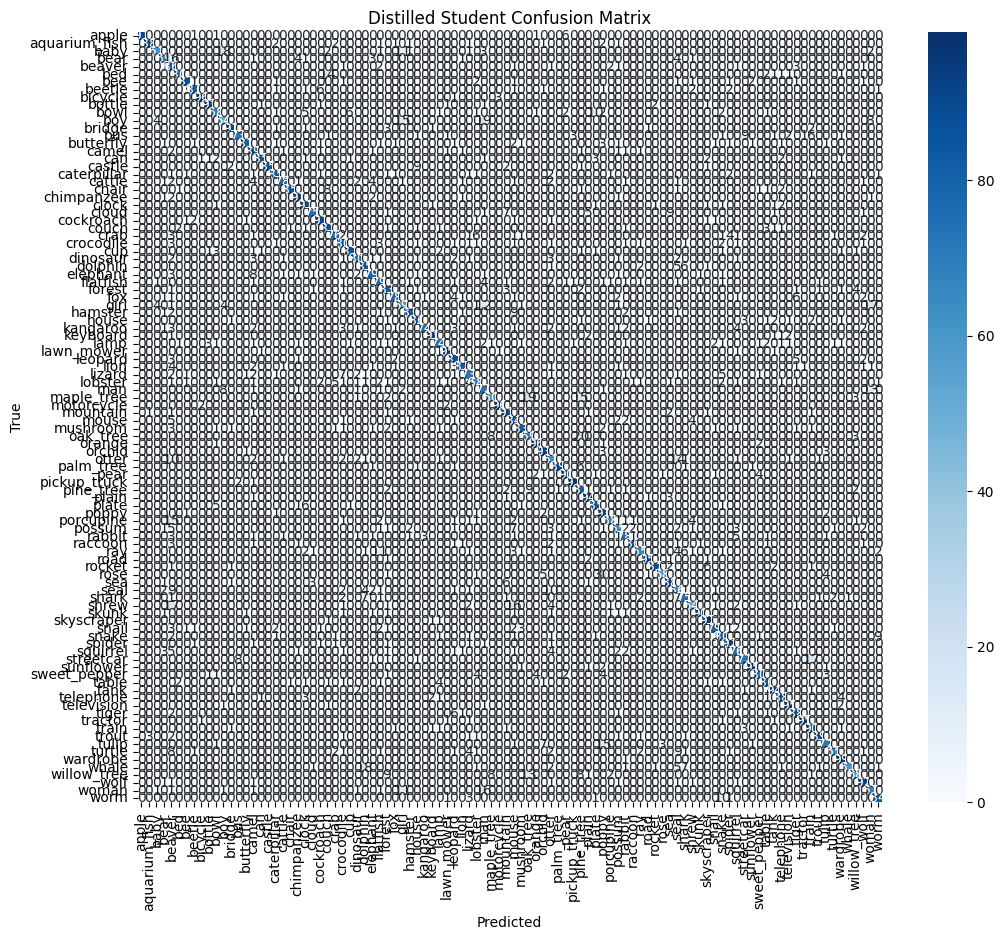

Distilled Student Per-Class Accuracy:
apple: 91.00%
aquarium_fish: 88.00%
baby: 61.00%
bear: 69.00%
beaver: 86.00%
bed: 80.00%
bee: 87.00%
beetle: 83.00%
bicycle: 96.00%
bottle: 93.00%
bowl: 68.00%
boy: 54.00%
bridge: 91.00%
bus: 73.00%
butterfly: 81.00%
camel: 89.00%
can: 85.00%
castle: 85.00%
caterpillar: 85.00%
cattle: 78.00%
chair: 85.00%
chimpanzee: 92.00%
clock: 91.00%
cloud: 75.00%
cockroach: 91.00%
couch: 87.00%
crab: 76.00%
crocodile: 80.00%
cup: 87.00%
dinosaur: 80.00%
dolphin: 85.00%
elephant: 79.00%
flatfish: 79.00%
forest: 83.00%
fox: 78.00%
girl: 59.00%
hamster: 83.00%
house: 86.00%
kangaroo: 74.00%
keyboard: 93.00%
lamp: 74.00%
lawn_mower: 95.00%
leopard: 87.00%
lion: 82.00%
lizard: 73.00%
lobster: 68.00%
man: 72.00%
maple_tree: 60.00%
motorcycle: 96.00%
mountain: 91.00%
mouse: 84.00%
mushroom: 83.00%
oak_tree: 69.00%
orange: 96.00%
orchid: 93.00%
otter: 63.00%
palm_tree: 89.00%
pear: 90.00%
pickup_truck: 97.00%
pine_tree: 81.00%
plain: 94.00%
plate: 85.00%
poppy: 93.00%

In [ ]:


# Define test transforms using normalization of 0.5
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-100 test set
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the given dataloader.
    Returns overall accuracy (%), total inference time (sec),
    and the collected predictions and true labels.
    """
    model.eval()
    total, correct = 0, 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # For distillation, the model returns (logits, projected_features)
            outputs = model(inputs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            preds = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    inference_time = time.time() - start_time
    accuracy = (correct / total) * 100.0
    return accuracy, inference_time, np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def per_class_accuracy(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = {}
    for i, label in enumerate(classes):
        total = cm[i, :].sum()
        per_class_acc[label] = 100.0 * cm[i, i] / total if total != 0 else 0.0
    return per_class_acc

def count_params(model):
    """Return the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ------------------------------
# Load the Best Distilled Student Checkpoint (30-epoch run)
# ------------------------------
distill_checkpoint_path = os.path.join('distill_checkpoints', 'student_best.pth')
checkpoint = torch.load(distill_checkpoint_path, map_location=device)
# student_with_proj is assumed to be your distilled student model instance
student_with_proj.load_state_dict(checkpoint['model_state_dict'])
student_with_proj.to(device)

# Print number of parameters for the distilled student model
distill_student_params = count_params(student_with_proj)
print(f"Distilled Student Parameters: {distill_student_params}")

# CIFAR-100 class names
classes = test_dataset.classes

# Evaluate the distilled student model
test_accuracy, total_inference_time, all_preds, all_labels = evaluate_model(student_with_proj, test_loader, device)
avg_inference_time = total_inference_time / len(test_loader)
print(f"\nDistilled Student Test Accuracy: {test_accuracy:.2f}%")
print(f"Distilled Student Average Inference Time per Batch: {avg_inference_time:.4f} seconds")


# Print classification report for the distilled student model
print("\nDistilled Student Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Plot confusion matrix for the distilled student model
plot_confusion_matrix(all_labels, all_preds, classes, title="Distilled Student Confusion Matrix")

# Compute and print per-class accuracy for the distilled student model
student_per_class = per_class_accuracy(all_labels, all_preds, classes)
print("Distilled Student Per-Class Accuracy:")
for cls, acc in student_per_class.items():
    print(f"{cls}: {acc:.2f}%")
